# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer() #HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=1)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 6322, 'TN': 56468, 'FP': 58238, 'FN': 6628, 'Accuracy': 0.4918687723256251, 'Precision': 0.09792441140024784, 'Recall': 0.48818532818532817, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12848, 'TN': 114623, 'FP': 83, 'FN': 102, 'Accuracy': 0.9985507927555305, 'Precision': 0.9935813162168432, 'Recall': 0.9921235521235521, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12912, 'TN': 114661, 'FP': 45, 'FN': 38, 'Accuracy': 0.9993498151281569, 'Precision': 0.9965269738365362, 'Recall': 0.9970656370656371, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12788, 'TN': 104468, 'FP': 10238, 'FN': 162, 'Accuracy': 0.918531052202795, 'Precision': 0.555372187961435, 'Recall': 0.9874903474903475, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12866, 'TN': 114646, 'FP': 60, 'FN': 84, 'Accuracy': 0.9988719684151156, 'Precision': 0.9953581927897261, 'Recall': 0.9935135135135135, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12081, 'TN': 114565, 'FP': 141, 'FN': 869, 'Accuracy': 0.9920881118004637, 'Precision': 0.9884634266077565, 'Recall': 0.9328957528957529, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 0, 'TN': 114706, 'FP': 0, 'FN': 12950, 'Accuracy': 0.8985554928871342, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/xichen/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

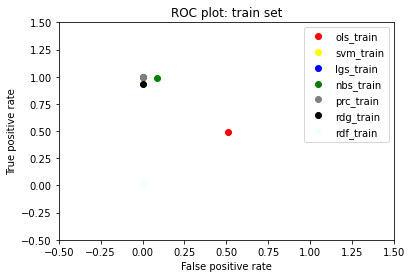

In [13]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

'''
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
'''

colors = ['red','yellow','blue','green','gray','black','azure']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [14]:
ols_predictions = ols.predict(X_train)

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
70
Well spotted. I've removed it as I can't immediately find a source for this.
* * * * * * * * * 
176
I believe that everything that I have added and/or restored has a proper reference.
* * * * * * * * * 
183
Praise 

looked at this article about 6 months ago -much improved. ]
* * * * * * * * * 
288
What about me sweetie? Am I more your speed?
* * * * * * * * * 
305
why 

why are you gonna block me
* * * * * * * * * 
399
"

I have nominated Boeing 787 Dreamliner for a featured article review here. Please join the discussion on whether this article meets featured article criteria. Articles are typically reviewed for two weeks. If substantial concerns are not addressed during the review period, the article will be moved to the Featured Article Removal Candidates list for a further period, where editors may declare ""Keep"" or ""Delist"" the article's featured status. The instructions for the review process are here.

"
* * * * * * * * * 
434
Hi Kking2013. I 

5037
Well needing residence permits is understandable (for some) but not being in Schengen benefits nobody and harms all... With Schengen there would be NO queues whatsoever which I am sure all Gibraltarians are sick of. In this case, as Gibnews has pointed out, its not Spain which is responsible for this problem...
* * * * * * * * * 
5063
Indiana Wesleyan University 

I appreciate you creating the Indiana Wesleyan Wildcats article and shortening the IWU main article- good idea. However, I've noticed that major contributions such as conference and national titles usually are included on the main article. For instance, note the UCLA and University of Southern California articles. Even though they have separate athletic articles, they both still list all their championships.
* * * * * * * * * 
5075
Fluffernutter, Drmies, Bilby,

Source: http://www.nrc.nl/handelsblad/van/1999/juni/16/ik-kan-niet-als-enige-gelijk-hebben-7451175

Please note that my other criticism of the article is also va

9785
Keep the original title at Xbox, although you can have additional likes like XBOX and X-box that redirect to this article.
* * * * * * * * * 
9794
A question about a deleted article 

Hi, I'm new here and I was wondering if I could ask you a question. I asked this question on the noticeboards but I hope it's okay that I just paste what I wrote. The reason for this is because it concerns an article that you deleted.

 
 

I wasn't sure where this should go but anyway. Upon investigation I found out that a previous page called Victoria Preobrazhenskaya was deleted as db-g11. It seems that the user has resurrected that page and is planning on writing up another one. Contribs shows no other edits than the project at hand. That's why I didn't know where this should go.. it's a user page and not an actual article. I've looked all over but I can't seem to find any protocol for such a situation even though I've encountered it a couple of times. When a user starts making an autobiographica

14180
Adopt Me (A Probably Smart Way To Go) 

Hi, uh, I'd like to be ADOPTED. I believe that would be the best way to go. Here's the link.

Thanks. I'd prefer Airplaneman, Access Denied, or the new MONO.
* * * * * * * * * 
14191
Note that the Sandbox is the right place to experment.  Thanks!
* * * * * * * * * 
14202
Your constant editing of other people's comments on talk pages is now being considered vandalism. You will stop now, or you will be face administrative sanction now. ~~~~
* * * * * * * * * 
14304
"
Looks good to me.   Talk  "
* * * * * * * * * 
14347
", 29 January 2010 (UTC)

 Object ""everyone and their granny"" is not sourcing.   14:33"
* * * * * * * * * 
14358
"

 I did not ask why you believe Singer's view is ""obviously fringe"", but even so I do not agree that ANY opinion not in line with mainstream is automatically fringe. What I did ask was which wikipedia policy you are using as the basis of the claim that her opinion should either be mentioned ""with apropriate ba

19098
"
Might be, though the word xenofobi is used as such. But most importantly I just noticed that the sources used are quite weird. Title: ""Resumé: Kallade SD för främlingsfientliga – frias av Granskningsnämnden""; the articles are about that SD was called anti-immigrant and someone from SD lodged a complaint. The broadcasting commission said that it was O.K. to call them that, but obviously did not conclude whether that is the most accurate description. Instead of sources like these, we'd better use original sources that call them främligsfientlighet, not some broadcasting commission complaint reviews. ' "
* * * * * * * * * 
19124
"

 Capitalizing ""The"" in the Beatles? 

Why are you revising Beatles-related articles in order to capitalize the initial ""T"" in ""the Beatles""?  Proper literary style would have the group's name spelled as ""the Beatles,"" not ""The Beatles.""  All recognized authorities who have published books on the Beatles (including Mark Lewisohn, Bob Spitz, N

 WikiProject Louisville An invitation to join us! Your recent edits seem to indicate that you have some local knowledge of Louisville, Kentucky. If so, perhaps you would like to join WikiProject Louisville, a project for the creation, expansion and improvement of articles related to metropolitan Louisville. Check out our project page, and if you like what you see, join us by adding your name to our membership list. Hope to see you at WikiProject Louisville!  Talk • Work "
* * * * * * * * * 
23239
...comparing this show to others without an improvement-to-article suggestion.
* * * * * * * * * 
23276
"
User:Timbouctou, you've been reported.

Calapone, please do not read too much into Timbouctou's comment above. Provocations ruin discussions, they do not help them along. A YouTube clip does absolutely nothing to show which flag was predominantly in official use. You must understand it has to be entirely disregarded. As things go around here, since the red-square-first chequy was in the ar

27519
If you say he can't, that means he can.
* * * * * * * * * 
27530
Request for Arbitration 

You have been summoned to appear as defendant at a Request for Abritation. Please vist the Wikipedia:Requests for arbitration page to make your statement under the heading .
* * * * * * * * * 
27541
Well thanks for all your Bundeswehr Heer additions too. Those divisions have waited years to have pages of their own.  (talk)
* * * * * * * * * 
27548
"

Sure thing my friend: if you read my first message, you will find i provided a wikilink called REDIRECT, you can learn all about that there. It's quite simple, man: right now, the article's name is VALENCIA CF and, unless someone changes it to VALENCIA C.F. (it can be done by registered users like me and you) it creates a series of problems with the mentioned redirects. Also, i would not change it because it would be too much trouble changing all the articles (and i guess there must be hundreds!) from CF to C.F.

Hope i helped, whistle if you n

32433
Wikimedia Stories Project 

Hello,

My name is Victor Grigas, and I'm a storyteller at the Wikimedia foundation. We're telling stories of Wikipedia users, editors, donors, programmers and staff to paint a picture of who uses Wikipedia - for the 2011 fundraiser.

I am in the process of planning a trip to India to gather stories from Indian Wikipedians in face-to-face interviews (possibly on video). 

My primary goal is to conduct 15-20 interviews, and hopefully enough of my interviews will make compelling stories that will effectively solicit donations from the public. These stories may also be used for other communication purposes by the foundation.

I found your userpage on a list of prolific Wikipedians and thought I’d reach out to you. Prolific editing is always a good story to tell!

If you are interested in participating, please contact me via my email:

vgrigas@wikimedia.org

Thank you for your time!

Victor

About me:
I have been a Wikipedia editor since 2005, and have a b

36834
"
He said that SOA Watch can be used, but its a 'weak source' I don't even agree with that. They are the premier researchers on the school/institue. They have filed FOIAs and and discovered the hundreds of human rights abusers who went to the school. They work with news medias and HROs all over Latin America to track these graduates and see when they commit crimes in their home countries and report them. I agree that we cant say 'WHINSEC is bad' only because SOAW says 'they're bad', but look at what happened yesterday. I added info on a legislative action. No one is going to argue that the SOAW made it up that there was a legislative action. It was first linked to SOAW. Someone removed it. It was then linked to a Catholic HRO. Someone removed it. Thats silly. Are we going to use SOAW as long as we say 'according to SOAW' or similar? What about my feelings above. the 7x and 1/7? If this article is going to be 50% on the last 6 years and all these 'changes' and not the decades befo

42124
I will also add that by being deliberately incivil in an effort to get people to admit that incivility is bad (duh), you are not only violating WP:CIVIL yourself but also WP:POINT. Yet note carefully that we are discussing this with you, not blocking you or hauling you before arbcom. Sometimes the best thing to do is tell someone you are disappointed with their behavior and leave it at that. —
* * * * * * * * * 
42200
Sprotected 

Your page because of vandalism.  Let me know when you want it lifted.  Cheers     धर्म
* * * * * * * * * 
42246
What's the weather like on the island at the moment? It's well dark here, and not so warm, so I'm off to bed. zzzzz
* * * * * * * * * 
42346
REDIRECT Talk:Third man argument
* * * * * * * * * 
42452
"

New Pages update
Hey  ). A quick update on how things are going with the New Page Triage/New Pages Feed project. As the enwiki page notes, the project is divided into two chunks: the ""list view"" (essentially an updated version of Special:NewPa

46416
"

Your edit on the page on Islamopobia is evil. Your comments could result in deaths of innocent lives. The truth needs to be shared.

Quran (8:12) - ""I will cast terror into the hearts of those who disbelieve. Therefore strike off their heads and strike off every fingertip of them"" 

Do not censor Wikipedia. Do not silence the truth.

"
* * * * * * * * * 
46506
since an admin has been summoned, I will wait for him or her.   I will also keep my word, of my last warning.  I was not aware of the arbcom notice when i wrote that; if i had been aware i would have gone directly to AE instead of issuing the last warning.
* * * * * * * * * 
46604
"
Try paying closer attention: the Examiner article pre-dates the show ""The Dating Guy"", as well as Sohmer's stated timetable of being made aware of its existence and the circumstances of its similarity to (what he considers the uncredited/unpaid use of) the IP he had already developed. Saying the Examiner ""avoided"" mentioning an unfair o

50763
No! It does not! what is its source for its 2.000.000 Turkmans in Iraq! This number was already proven to be an exaggeration by Turkman nationalist and this was agreed upon not to be in the infobox.
* * * * * * * * * 
50779
. However, there are tags that were added to this picture that shouldn't be there
* * * * * * * * * 
50856
Cquote 

Please restore the template. We have WP:TfD for a reason. This is not the way to go about it. I would hate to see a bunch of admins edit warring over this, it is no good for anyone. I would ask that you please restore it before I make further requests elsewhere.
* * * * * * * * * 
50869
":""Emo has a specific meaning, like banana, not an all-inclusive one, like fruit.""  I could not possibly disagree more.

It's impossible to split the ""historical"" and ""popular"" notions of emo because they're the same thing.

Since my ""grunge"" example failed, here's another: ""Hip hop"".  In the 80s, ""hip hop"" described dance-influenced music that feature

54928
Thanks 
For the help sorting the mission grounds thing.  talk
* * * * * * * * * 
55044
Tool 4 ur ma 

Unfortunately, there's no actual law against being a Tool, so just get ur tool also in ur roten ma's...
* * * * * * * * * 
55124
the information you provide will not be shared with third parties other than to assist us in analyzing the results of the survey; the WMF will not use the information to identify you
* * * * * * * * * 
55150
delete a section
The Personal Life section should probably be removed, as it lists many non notable people.
* * * * * * * * * 
55196
April 2015 (UTC)
Actually MacKinnoins quote is how she defines genocidal rape, which is why it is in there, just behind the internal to the article on Genocidal rape. So why does a definition not belong in the article?   10:08, 28
* * * * * * * * * 
55220
removal of a forum link from the folkestone page 

Just wondering why you removed the folkestone forums link from the folkestone page, and not the onfolkestone forums

59231
July 2011 

 Please stop adding inappropriate external links to Wikipedia, as you did to Buddhist art. It is considered spamming and Wikipedia is not a vehicle for advertising or promotion. Because Wikipedia uses nofollow tags, additions of links to Wikipedia will not alter search engine rankings. If you continue spamming, you may be blocked from editing Wikipedia.  - ™
* * * * * * * * * 
59250
WikiProject Board and table games
* * * * * * * * * 
59295
Why doesn't this article talk about how Jimbo got the Wikimedia credit card taken away cuz he used it to purchase prostitutes in Moscow??? Why should i donate to Wikimedia with this crook in charge?68.185.206.4
* * * * * * * * * 
59370
"
Please stop adding nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.    (T | C | k) "
* * * * * * * * * 
59406
It is cancer to be scary for we hibakusya which became old. This cancer breaks out not a recurrence or metastasis sporadically

63672
"

Due to being an obvious POV violation, I removed the wording ""was a traitor to Mexico and her people"" from the section about his signing the treaty with Spain.  "
* * * * * * * * * 
63703
I have not vandalized the page and edited in derogatory information, I have merely undone some of your bad faith changes and this is clearly something you are taking personally.  I see that you have a similar approach to other pages and have had repeated conflicts regarding this.  I suggest you find a more productive use of your time or, barring that, you contribute to the page in a manner which does not reflect your personal bias and/or need to wield authority.  (98.212.132.208  )
* * * * * * * * * 
63719
"

IP range unblock
I request the ""North Carolina vandal"" range be unblocked. I was making those death rumors to arouse Curps' attention. Anyway, I finally feel as if I could be becoming a good contributor. Please unblock my range so I can start by removing span from list of wikis.  "
*

68068
"

Shows so well my point about power trips.  Are you a jury?  Because only a jury can determine libel.  Did Niles sue Busch for his entry?  Did he sue Murphy?  No.  Wonder why?  Because the truth is an absolute defense to libel.  As far as threatening me (""my own risk"") does that jollify you?  Like somehow you matter?  Just wondering.  ColScott"
* * * * * * * * * 
68124
politician-work-group=yes}}
{{WikiProject South America|class=Stub|importance=|Falkland Islands=yes|Falkland-Islands-
* * * * * * * * * 
68136
"
I will definitely wait for your answer. I'll think about it too. I also think that we have to know the ""Why"" of its bad success and then try to change it in our own favour.  (zootalk) "
* * * * * * * * * 
68200
"

 Oi 

  Why did you move the page ""Give You The World"" to ""Give You the World""? It looks dumb now because only one word is not capitalised."
* * * * * * * * * 
68284
, if this block is for violating 3rr, why did you not block , who clearly violated 3rr?

72352
Arbcom 

indefblocked users may certainly be brough up for arbitration.  they participate via their talkpage.  see [:::umm.. indefblocked users may certainly be brought up in front of arbcom.  they this link.  thanks for looking out though.  -)  /
* * * * * * * * * 
72358
it is probably better to discuss the content issues here on this page so that the discussion is here or in archives here for future editors to see rather than hidden in archives of a different page.   fan
* * * * * * * * * 
72378
"
A tag has been placed on Gregg S. Epstein, requesting that it be speedily deleted from Wikipedia. This has been done because the article seems to be about a person, group of people, band, club, company, or web content, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not assert the subject's importance or significance may be deleted at a

76814
"font>]]am 23:29, 12 December 2012"
* * * * * * * * * 
76901
Not actually. Look at Olethros and look up the scriptures that Olethros is in store for goats.
* * * * * * * * * 
76941
This was placed here by the vandal
* * * * * * * * * 
77000
Please stop. If you continue to vandalize Wikipedia, you will be blocked from editing. . There was no need for it
* * * * * * * * * 
77007
"

 Intro 

The figures used in the introduction are not exact and I am well aware of this. They are not exact for the sake of easy reading (it is irritating to digest such long-winded figures when one just wants to get the 'gist' of the article), and not for any other motive (the LM is gone and dead, there is no reason to ""beef them up""). The exact figures are available later on in the article.  talk "
* * * * * * * * * 
77013
So the party has started ... but The woods are lovely, dark and deep.But I have promises to keep, and miles to go before I sleep,and miles to go before I sleep.Robert Frost
* * * *

81178
" May 2011 (UTC)
Consensus does appear to go that way but it looks like ""no consensus"" is also close. However, those dissenting point out the other names are still more prominent. That was not mentioned in the opening statement but has been brought up by more than one editor. We actually have a previous version of the lead with all of the more prominent names listed so we can go back to that. I still don;t mind saying ""Gaza Massacre"" in the lead (it is verifiable) as long as prominence is taken care of.   05:24, 11"
* * * * * * * * * 
81225
Please see 

Wikipedia talk:WikiProject Rugby league on whether to create the pages for the tests between AUS VS NZ (this friday} AND ENG VS FRA (in june)
* * * * * * * * * 
81258
You have the official club list why is that not suitable as being the truth?
* * * * * * * * * 
81266
"
""War has just begun"" is not a threat."
* * * * * * * * * 
81273
"::: Monkeykiss, Stephen I agree with you. I will ad the socio-political implications in the 

85906
":::::*Regarding the loss of material, omnibus song articles do not place the cover song subject in context, they do not provide a representative survey of the relevant cover song literature, and, as a result, they impart a bias into Wikipedia's coverage of cover songs. We do not have ""the film"" articles that limit Wikipedia's coverage of film remakes to the film because policy and guidelines are enforce for film remakes.     
"
* * * * * * * * * 
85916
"
One could argue that ""personal analysis"" is misapplied when one employs a concept defined by wp to a discussion in wp about that very subject. What is the purpose of having a definition of ""massacre"" but then not employing it, particularly in controversial conditions? one might argue that by not addressing the wp defined ""massacre"" to what happened in Deir Yassin that the concept NPOV, another wp defined concept could be employed when the subject concept is employed. If wp defined concepts are to be abandoned then are we

91084
KCB Group 

. 
I would like to make major edits to Kenya Commercial Bank Group and its subsidiaries. Would that be okay?   19:30, May 28, 2015 (EAT)
* * * * * * * * * 
91158
Do you research, find the sources yourself and see that I am right. I was BROUGHT UP with this music, message the bands and you will have your sources. I will give you links to their official pages if you desire. I did not insult you, I schooled you. Seems to me, you can't take it. It is not my personal opinon at all, it is a fact and if you message the bands you will see it. Block me if you like, but it just shows that you're site in an unreliable information source. Which it is. I came here to help but seems you like being wrong about everything here.
* * * * * * * * * 
91171
"
What are you talking about??? Did you read the reference at all??? In one of them you can read: ""outrage and disgust in the wake of a massive show of fascist salutes, symbols and uniforms at a rock concert by popular ultra-nationali

95386
Well done, you're smart aren't you. We edit together.
* * * * * * * * * 
95407
Ping: User talk:Born2cycle 

I thought you might want to know that you have replies at User talk:Born2cycle, if you weren’t watching the page. Cheers. —174.141.182.82
* * * * * * * * * 
95439
I've started the ball rolling at Template:LGBT topics. Thought I'd start off by coming up with headings and organising articles under them...  -WJB talk-
* * * * * * * * * 
95488
Thanks for the suggestion, but I'm not interested in implementing that feature at this time. Users will see the change to the new image on their watchlists and should be able to update their watchlists accordingly. Ideally, users would realize that if they save their images in PNG format before uploading, they can avoid the watchlist issue entirely. Thanks again for the suggestion, I am glad to hear them! — (t)
* * * * * * * * * 
95512
Recatting, etc.
Nice shots - I'd like to get over there myself someday.

As for the recatting, I'll get 

"

 Categories 

As per WP:RDR#Categories for redirect pages and Wikipedia:Categorizing redirects it seems some categorization aside from ""Type of redirect"" is allowed.

In this case, the categories are to allow ease of navigation for readers using the categories to find specific things.

2007 in comics is especially pertinent since it only apples to a subsection of the target article and it would be misleading to apply to the article as a whole.

DC Comics storylines and Superhero comics it is an issue of completeness - using those as a navigation aid to find specific title is easier if the title is there, even if it is a redirect.

-   "
* * * * * * * * * 
99665
Chorley was established as a Rugby Union club in 1875 and opted to become an Association Football club in 1883 according to here.
* * * * * * * * * 
99735
"
 Also, you want me to rename that file? ''''''  "
* * * * * * * * * 
99778
BODGED NOSE

matty love allison
* * * * * * * * * 
99943
That most definitely was not me, the

103917
Is it possible that you can unprotect my talk page?
* * * * * * * * * 
103950
"

Morons of Wikipedia, read the sources provided ""Pre-Contact-1500 BC - The epic story of the west to east migration of the Lenni Lanape, ancient ancestors of the Anishinabe people, begins and is recorded as the Wallum Olum (an ancient written record on bark tablets and song sticks). It is the oldest written record of people in North America and dates back to before 1600 B.C.""  — Preceding unsigned comment added by 166.147.120.26   "
* * * * * * * * * 
104028
"

Love history & culture? Get involved in WikiProject World Digital Library!

World Digital Library Wikipedia Partnership - We need you!Hi ! I'm the Wikipedian In Residence at the World Digital Library, a project of the Library of Congress and UNESCO. I'm recruiting Wikipedians who are passionate about history & culture to participate in improving Wikipedia using the WDL's vast free online resources. Participants can earn our awesome WDL barns

109043
"# Peter's job situation
 Peter and the giant chicken (two episodes so far and a third bout has been promised)
 Lois's wealthy Pewterschmidt background
 Chris's interest in drawing, painting
 The evil monkey in Chris's closet
 The old pervert who's interested in Chris
 ""Meg does her bird calls"" (just two episodes, but still)
 Stewie's brother Bertram
 Brian went to Brown
 Brian's feelings for Lois
 Peter rolled up the window in the General Lee and Brian got smacked up on it
 Stewie teases Brian about his novel
 The Browns' divorce
 Quagmire's job as a pilot
 ""Joe had his accident at Christmastime""
 The medical barbershop quartet
 Goldman's Pharmacy was established in 1983

 Name origin  

Does anyone know the origin of the name Peter Griffin?

 Qoutes 

Some of the quotes need checking.  
There are different versions on the web, but some of them are only found in this article, which makes me think they are too different from the original.
Some of the quotes (such as ""I am o

113820
I disagree with your characterization and have restored the citation.
* * * * * * * * * 
113856
Interesting 

Only way to keep the POV going is to ban all dissent. How Stalin of you! And OM does to his opposition just what was done to his 'brethren'. He is a mirror image of what he complains about.
* * * * * * * * * 
114078
Hey Fisha! It's me from EA Sports. Just thought that I'd say hi and I also wanted to tell you that you had some well thoughtout, intelligent questions about NASCAR 08 and I'm glad that EA got to yours before anyone elses. I was pretty upset when everyone started hassling you because of that. Bye for now!
* * * * * * * * * 
114122
As to your threat of requesting the deletion of Theology of Martin Luther, you would do that out of the spite no less. Perhaps you should review WP:Point.
* * * * * * * * * 
114131
I just read it again having not looked at the article for two day. Its significantly improved. Very nice work.
* * * * * * * * * 
114153
"
This IP is shar

118696
"
While in August 19, jimbo did change it to guideline, it was disputed for some time afterwards. SWATJester Denny Crane. "
* * * * * * * * * 
118967
"

Tell me More!
Ok, how that i've reached 100 edits, tell me how to make a nav header. Bye 8]  Defender and Ruler of Cyberspace! "
* * * * * * * * * 
118986
"

The Spider
Hiya LittleWink, I don't think this revert is correct. Al-Ankabut is most certainly ""The Spider""  (see List of Quranic suras)- no ambiguity as in some other translations. This is English Wikipedia so it is not clear to me why each sura has an Arabic title; but Sura 29 is most definitely titled ""The Spider"".   "
* * * * * * * * * 
119000
"

Geographically, no matter how you look at it, we are not part of Asia but are our own continent. Heck, other continents such as Europe and Africa actually touch the continent of Asia, something that Australia does not do. Now, no one would ever claim that ""Europe and Africa are geographically Asian"". Even the North Americ

123614
I have removed Pope John Paul II's death from list of tragedies along w/ Christine Dewitts birth. Neith constitute a tragedy. do not re-add them.
* * * * * * * * * 
123634
"(Some days later:) I've WP:BOLDLY put back a much shorter version of the argument from ""pseudo-kerning"", citing Dr Newcomer as the source. Here's a copy:
Inter-character spacing
Joseph Newcomer, an expert cited by critics of the memos, claims that the memos display a simple alternative to kerning characteristic of TrueType fonts but not available on any office equipment in 1972. For example, in words containing ""fr"", TrueType moves the ""r"" left to tuck it in under the top part of the ""f"".{{cite web | title=The Bush ""Guard memos"" are forgeries! | url=http://www.flounder.com/bush2.htm | author=Joseph Newcomer | date=2004-09-15 | accessdate=2007-01-29 }}
Please note that my version uses Newcomer as a primary source, and so plainly is quite acceptable per WP:RS and WP:V#SELF. Cheers, (talk) 

"
* * * * 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [16]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 1662, 'TN': 13918, 'FP': 14722, 'FN': 1613, 'Accuracy': 0.48817170609431304, 'Precision': 0.1014404296875, 'Recall': 0.5074809160305344, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2109, 'TN': 27383, 'FP': 1257, 'FN': 1166, 'Accuracy': 0.9240795864013787, 'Precision': 0.6265597147950089, 'Recall': 0.6439694656488549, 'desc': 'svm_test'}


### MODEL: logistic regression

In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2067, 'TN': 27415, 'FP': 1225, 'FN': 1208, 'Accuracy': 0.9237662541124863, 'Precision': 0.6278857837181046, 'Recall': 0.6311450381679389, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2522, 'TN': 19206, 'FP': 9434, 'FN': 753, 'Accuracy': 0.6808083973053423, 'Precision': 0.2109401137504182, 'Recall': 0.7700763358778626, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2102, 'TN': 27432, 'FP': 1208, 'FN': 1173, 'Accuracy': 0.9253955820147266, 'Precision': 0.6350453172205438, 'Recall': 0.6418320610687023, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 1853, 'TN': 26904, 'FP': 1736, 'FN': 1422, 'Accuracy': 0.9010496631677894, 'Precision': 0.5162998049595988, 'Recall': 0.5658015267175572, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 0, 'TN': 28640, 'FP': 0, 'FN': 3275, 'Accuracy': 0.8973836753877487, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


/Users/xichen/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

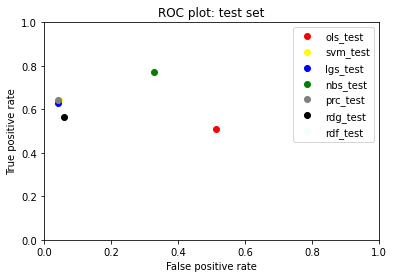

In [23]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
colors = ['red','yellow','blue','green','gray','black','azure']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [24]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./toxiccomments_test.csv', my_random_seed=1, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of CountVectorizer X:
(153164, 189775)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6         

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = prc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.2038664438118618


In [26]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [27]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [28]:
my_submission.shape

(153164, 2)

In [29]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation